In [0]:
%matplotlib inline

## Style Transfer - with PyTorch and Google Colab

Created for TMCS software development course, 2019

To perform a style transfer is to take any arbitrary image and process it such that it takes on the stylistic features of another image fed in to the algorithm. The procedure for doing this is described in *A Neural Algorithm of Artistic Style*, paper of L.A. Gatys, A.S. Ecker, and M. Bethge - linked
[here](https://arxiv.org/pdf/1508.06576.pdf) .

![what style transfer looks like](https://cdn-images-1.medium.com/max/2000/1*uIlgYKjp-1ZboXK8ff6ztg.jpeg)
My reason for choosing to use a Google Colab notebook for this project is that you will be performing operations on large tensor objects. Such tasks are highly parallelisable and Google provides GPUs that you all can use for free via a browser, without having to deal with CUDA, which should hopefully speed up the development process since you won't have to wait long for the network to train.

This notebook will provide a framework that you will use to write your own modules that, once they pass the tests given below, will come together on Friday  - BYOP (bring your own pictures).

The algorithm itself is simple - it takes a style image, a content image, and an input (seed) image and uses a pre-trained convolutional neural net to output a style transfered image. We define two distances - content and style - that measure how far the input image is from the other two, then use gradient descent to minimise both. A good explanation, including a detailed section on CNNs, is given [here](https://towardsdatascience.com/a-neural-algorithm-of-artistic-style-a-modern-form-of-creation-d39a6ac7e715).

# Packages, GPUs and TPUs

The packages that we will be using to build this program are:

*   ``pytorch`` - necessary for working with neural networks ([documentation](https://pytorch.org/docs/stable/index.html))
*   ``pillow`` - THE python imaging library ([documentation](https://pillow.readthedocs.io/en/stable/))
* ``numpy`` and ``matplotlib.pyplot`` - standard, and necessary for pythonic number crunching and plotting

Image processing takes a lot less time to run on a GPU, and when you work in Colab you can use them for free - go to *Runtime -> Change Runtime Type* and set Hardware accelerator to GPU/TPU.

In [0]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from io import BytesIO
import requests

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Load and prepare the input images

This function ought to import the style and content images. It must ensure that both images are the same size and return a torch tensor that can be used for subsequent operations. Note that you will need to insert a fake batch dimension into the output tensor, which is required to fit the VGG neural network's input dimensions - that is (batch_size, num_channels, height, width).

Then, build a function that displays the images, to ensure they've loaded correctly.

In [0]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_url="https://orpheogroup.com/it/wp-content/uploads/2018/10/Escher.jpg"
content_url="https://pbs.twimg.com/media/Cqg9A6wUIAAIRTP.jpg"

style_img = image_loader(BytesIO(requests.get(style_url).content))
content_img = image_loader(BytesIO(requests.get(content_url).content))

style_img = style_img[:,:,0:512,0:512]
content_img = content_img[:,:,0:512,0:512]

assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"

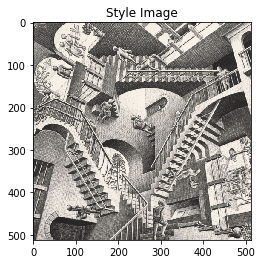

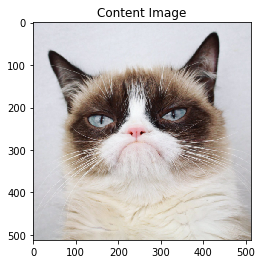

In [0]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

Then we can visualise the images we have uploaded

In [0]:
# Testing the function

assert type(style_img) == torch.Tensor, "The data type of the output is incorrect"
assert style_img.size() == content_img.size(), "The two input images are not the same size"
assert len(style_img.size()) == 4, "Wrong tensor dimension for NN"

Functions that generated the input image as whitenoise

In [0]:
def generate_whitenoise_image():
  whitenoise_image = torch.randn(style_img.size(),device=device)
  return whitenoise_image

In [0]:
# input_img = generate_whitenoise_image()
input_img = content_img

In [0]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

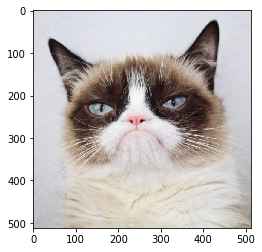

In [0]:
plt.figure()
plt.imshow(unloader(input_img.cpu().squeeze(0)))

In [0]:
def get_dimensions(content, style):
  
  torch.Tensor.size(content)
  print('Dimensions of content image are:', content)

  torch.Tensor.size(style)
  print('Dimensions of style image are:', content)

#Build the loss functions
**Content Loss**
is a function that represents the distance of the input image $I$ from the content image $C$ for an individual layer of the NN. We pass both images to the NN to get the intermediate feature representations at layer $l$. The loss function $L_{content}(I, S)$ should return the distance $|F_{Il} - F_{Cl}|^2$ which is the mean square error between the two sets of feature maps.


**Style Loss** is a little more involved to calculate, as can be seen in the paper. It involves the calculation of the gram matrix for that layer, for the style $S$ and input $I$ images. The gram matrix is the inner product between the vectorised feature map $i$ and $j$ in layer $l$: it represents the correlation between those feature maps.

The contribution of each layer to the total style loss is described by
$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}|G^{Sl}_{ij} - G^{Il}_{ij}|^2$$

where $G^{Il}_{ij}$ and $G^{Sl}_{ij}$ are the respective gram representations in layer $l$ of $I$ and $S$. $N_l$ describes the number of feature maps, each of size $M_l = height * width$. Thus, the total style loss across each layer is 
$$L_{style}(I, S) = \sum w_l E_l$$
where we weight the contribution of each layer's loss by some factor $w_l$.

In [0]:
def content_loss(input_image,content_image):
  return F.mse_loss(input_image,content_image)

def get_gram_matrix(input_tensor):
  
  c = len(input_tensor[0][0])
  d = len(input_tensor[0][0][0])
  
  G = torch.zeros(1,3,c,d)
  
  for colour in range(3):
    for i in range(c):
      for j in range(d):
        
        G_ij = 0
        
        for k in range(d):
          
          p = input_tensor[0][colour][i][k] * input_tensor[0][colour][j][k]
          
          G_ij += p
          
        G[0][colour][i][j] = G_ij
       
  return G
  
def style_loss(N,M,G,A):     # not sure about prefactors, this function per layer
  return (1./(4. * N * M) * F.mse_loss(G,A))

def total_style_loss(w_,E_):
  
  L_ = 0
  
  for i in range(len(w_)):
    
    L_ += (w_[i] * E_[i])
    
  return L_

def total_overall_final_loss(alpha,beta,styleloss,contentloss):
  return (alpha * contentloss) + (beta * styleloss)


class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
      
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)
  
  
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

#Import and normalise the neural network

Here, we import a pre-trained 19-layer VGG neural network, like that used in the paper. The VGG19 was developed for an image classification competition, scoring 7.3% error (that's very good). It contains 5 stacks of convolutional layers, with 2-4 layers in each  - they're named conv1_2 to conv5_4. A good explanation of how convolutional neural nets work can be found [here](https://www.youtube.com/watch?v=YRhxdVk_sIs).

![structure of VGG-19](https://cdn-images-1.medium.com/max/1600/1*cufAO77aeSWdShs3ba5ndg.jpeg)

PyTorch’s implementation of VGG is a module divided into two modules: features (containing convolution and pooling layers - maxpool and conv), and classifier (containing fully connected layers - FC1, FC2). We will use the features module because we need the output of the individual convolution layers to measure content and style loss. Some layers have different behavior during training than evaluation, so we must set the network to evaluation mode using .eval().

Note that VGG networks are trained on images with each channel normalized by mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]. You will need to normalize the image before sending it into the network.

In [0]:
vgg19 = models.vgg19(pretrained = True).features.eval().to(device)

In [0]:
for layer in vgg19.children():
  print (layer)

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace)
Conv2d(512, 512, kernel_size=(3, 3), stride

In [0]:
# using the the mean and std on which the VGG network has been trained 

vgg19_normalisation_mean = torch.tensor([0.485,0.456,0.406]).to(device)
vgg19_normalisation_std = torch.tensor([0.229,0.224,0.225]).to(device)

# creating a module that normalises the input image 
# then put it into nn.Sequential 
class Normalisation(nn.Module):
  def __init__(self,mean,std):
    super(Normalisation,self).__init__()
    #
    #
    #
    self.mean = torch.tensor(mean).view(-1,1,1)
    self.std = torch.tensor(std).view(-1,1,1)
   
  def forward(self,image):
    # normalise 
    return (image - self.mean) / self.std

In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(vgg19, normalisation_mean, normalisation_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    vgg19 = copy.deepcopy(vgg19)

    # normalisation module
    normalisation = Normalisation(normalisation_mean, normalisation_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalisation)

    i = 0  # increment every time we see a conv
    for layer in vgg19.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

#Gradient descent function

We want to train the input image in order to minimise the content/style losses. It's a good idea to use the existing L-BFGS algorithm in ``torch`` to run the gradient descent. Create a L-BFGS optimizer function that  accepts the image as a tensor, and returns an optimizer object.

In [0]:
def get_optimizer(image):
  optimizer = optim.LBFGS([image.requires_grad_()])
  return optimizer

Once all the above functions exist and work together, you can chain them into a single function that runs the style transfer!

In [0]:
# Build your run_style_transfer() function here!
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("Iteration {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Iteration [50]:
Style Loss : 3.027532 Content Loss: 2.147230

Iteration [100]:
Style Loss : 2.881151 Content Loss: 2.221579

Iteration [150]:
Style Loss : 2.917780 Content Loss: 2.443890

Iteration [200]:
Style Loss : 3.145147 Content Loss: 2.849857

Iteration [250]:
Style Loss : 3.699114 Content Loss: 4.588581

Iteration [300]:
Style Loss : 29.832136 Content Loss: 57.488426

Iteration [350]:
Style Loss : 3.541601 Content Loss: 4.296994

Iteration [400]:
Style Loss : 284.733215 Content Loss: 161.935028

Iteration [450]:
Style Loss : 4.431580 Content Loss: 6.353181

Iteration [500]:
Style Loss : 646.064392 Content Loss: 227.847092



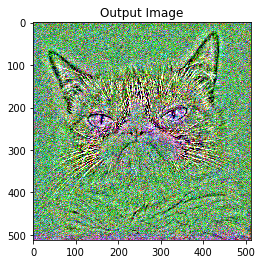

In [0]:
output = run_style_transfer(vgg19, vgg19_normalisation_mean, vgg19_normalisation_std,
                            content_img, style_img, input_img, style_weight=100, num_steps=500)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()